In [1]:
# 원본 코드 확인용
from torchvision import models
models.resnet

<module 'torchvision.models.resnet' from '/data/home/kseorang/.pyenv/versions/3.8.10/lib/python3.8/site-packages/torchvision/models/resnet.py'>

In [2]:
#train, test 함수 사용하기 위해 경로 추가
import sys
sys.path.append('/data/home/kseorang/Deep-Learning-Study')

import torch
from torchvision import transforms, datasets
import torch.nn as nn

from model import Model 
from TrainnTest import train, test

# 이미지 확인
from torchvision import utils
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

In [3]:
if torch.cuda.is_available():
    DEVICE = torch.device('cuda')
else:
    DEVICE = torch.device('cpu')
print('Using PyTorch version:', torch.__version__, ' Device:', DEVICE)

Using PyTorch version: 2.0.1+cu117  Device: cuda


In [4]:
BATCH_SIZE = 32
EPOCHS = 15

train_dataset = datasets.CIFAR10(root = "./data/",
                                 train = True,
                                 download = True,
                                 transform = transforms.Compose([
                                     transforms.RandomHorizontalFlip(),
                                     transforms.RandomVerticalFlip(),
                                     transforms.RandomChoice([
                                         transforms.ColorJitter(0.2, 0.2, 0.2, 0.2),
                                         transforms.RandomAffine(
                                             degrees=15, translate=(0.2, 0.2),
                                             scale=(0.8, 1.2), shear=15)]),
                                      transforms.ToTensor(),
                                      transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)), # ImageNet 데이터셋의 통계치
                                      ]))

test_dataset = datasets.CIFAR10(root = "./data/",
                                train = False,
                                transform = transforms.Compose([
                                    transforms.ToTensor(),
                                    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
                                    ]))

train_loader = torch.utils.data.DataLoader(dataset = train_dataset,
                                            batch_size = BATCH_SIZE,
                                            shuffle = True)

test_loader = torch.utils.data.DataLoader(dataset = test_dataset,
                                          batch_size = BATCH_SIZE,
                                          shuffle = False)

print(train_loader.dataset)
print(test_loader.dataset)

Files already downloaded and verified
Dataset CIFAR10
    Number of datapoints: 50000
    Root location: ./data/
    Split: Train
    StandardTransform
Transform: Compose(
               RandomHorizontalFlip(p=0.5)
               RandomVerticalFlip(p=0.5)
               RandomChoice(
               ColorJitter(brightness=(0.8, 1.2), contrast=(0.8, 1.2), saturation=(0.8, 1.2), hue=(-0.2, 0.2))
               RandomAffine(degrees=[-15.0, 15.0], translate=(0.2, 0.2), scale=(0.8, 1.2), shear=[-15.0, 15.0])
           )(p=None)
               ToTensor()
               Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))
           )
Dataset CIFAR10
    Number of datapoints: 10000
    Root location: ./data/
    Split: Test
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))
           )


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


image indices: [32798 45346 26263 49226]


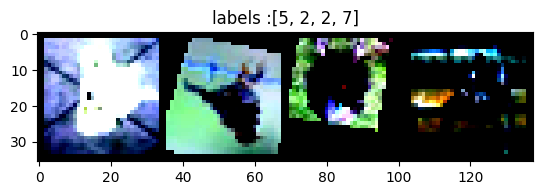

In [5]:
# 이미지 확인용
def show(img, y=None, color=True):
    npimg = img.numpy()
    npimg_tr = np.transpose(npimg, (1,2,0))
    plt.imshow(npimg_tr)

    if y is not None:
        plt.title('labels :' + str(y))

grid_size = 4
rnd_inds = np.random.randint(0, len(train_dataset), grid_size)
print('image indices:',rnd_inds)

x_grid = [train_dataset[i][0] for i in rnd_inds]
y_grid = [train_dataset[i][1] for i in rnd_inds]

x_grid = utils.make_grid(x_grid, nrow=grid_size, padding=2)

show(x_grid, y_grid)

In [6]:
model = Model().resnet50().to(DEVICE)
optimizer = torch.optim.SGD(model.parameters(), lr = 0.1, momentum=0.9, weight_decay=0.0001)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.1, patience=2, verbose=True)
criterion = nn.CrossEntropyLoss()
print(model)

ResNet(
  (conv1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): BottleNeck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU()
      (shortcut): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bia

In [7]:
train_acc_list = []
train_loss_list = []

test_acc_list = []
test_loss_list = []

for epoch in range(1, EPOCHS + 1):
    train_loss, train_accuracy = train(model, train_loader, optimizer, DEVICE, criterion, epoch, BATCH_SIZE)
    train_acc_list.append(train_accuracy)
    train_loss_list.append(train_loss)
    print("[EPOCH: {}] \tTrain Loss: {:.4f}, \tTrain Accuracy: {:.4f}".format(
        epoch, train_loss, train_accuracy))

    test_loss, test_accuracy = test(model, test_loader, DEVICE, criterion, BATCH_SIZE)
    scheduler.step(metrics=test_loss)  
    test_acc_list.append(test_accuracy)
    test_loss_list.append(test_loss)

    print("[EPOCH: {}] \tTest Loss: {:.4f}, \tTest Accuracy: {:.4f}\n".format(
        epoch, test_loss, test_accuracy))
    # 에폭당 학습률 확인(필요시)
    # l_r = [x["lr"] for x in optimizer.param_groups]
    # print("lr:{}\n".format(l_r))

[EPOCH: 1] 	Train Loss: 2.9017, 	Train Accuracy: 0.1251
[EPOCH: 1] 	Test Loss: 4.1469, 	Test Accuracy: 0.1694

[EPOCH: 2] 	Train Loss: 2.1320, 	Train Accuracy: 0.1777
[EPOCH: 2] 	Test Loss: 4.1118, 	Test Accuracy: 0.1994

[EPOCH: 3] 	Train Loss: 2.0593, 	Train Accuracy: 0.1976
[EPOCH: 3] 	Test Loss: 3.6002, 	Test Accuracy: 0.2259

[EPOCH: 4] 	Train Loss: 1.9903, 	Train Accuracy: 0.2283
[EPOCH: 4] 	Test Loss: 4.2818, 	Test Accuracy: 0.2642

[EPOCH: 5] 	Train Loss: 1.9465, 	Train Accuracy: 0.2515
[EPOCH: 5] 	Test Loss: 2.6546, 	Test Accuracy: 0.3065

[EPOCH: 6] 	Train Loss: 1.9278, 	Train Accuracy: 0.2662
[EPOCH: 6] 	Test Loss: 1.8751, 	Test Accuracy: 0.3285

[EPOCH: 7] 	Train Loss: 1.8792, 	Train Accuracy: 0.2900
[EPOCH: 7] 	Test Loss: 1.6928, 	Test Accuracy: 0.3494

[EPOCH: 8] 	Train Loss: 1.8423, 	Train Accuracy: 0.3106
[EPOCH: 8] 	Test Loss: 1.7925, 	Test Accuracy: 0.3233

[EPOCH: 9] 	Train Loss: 1.8105, 	Train Accuracy: 0.3294
[EPOCH: 9] 	Test Loss: 1.7840, 	Test Accuracy: 0.3572

[

0.4777


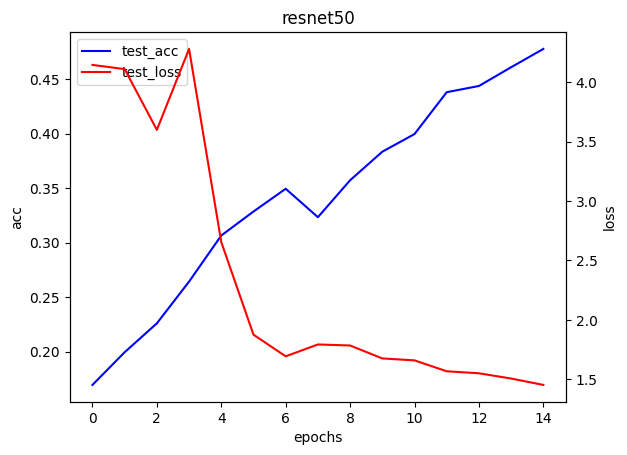

In [8]:
# 그래프 그리기
import os    
os.environ['KMP_DUPLICATE_LIB_OK']='True'

x = np.arange(len(test_acc_list))

fig, ax1 = plt.subplots()
ax1.plot(x, test_acc_list, label='test_acc', color='blue')
ax1.set_ylabel('acc')
ax2 = ax1.twinx()
ax2.plot(x, test_loss_list, label='test_loss', color='red')
ax2.set_ylabel('loss')
ax1.set_xlabel("epochs")

ax1.set_title('resnet50')

lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
lines = lines1 + lines2
labels = labels1 + labels2
ax1.legend(lines, labels, loc="upper left")

max_test_acc = max(test_acc_list)
print(max_test_acc)

In [9]:
# 모델 저장
PATH = './saved/resnet50/model.pth'
torch.save(model.state_dict(), PATH)

In [10]:
# 각 acc, loss txt파일에 저장
train_acc_list.insert(0, 'train_acc_list')
train_loss_list.insert(0, 'train_loss_list')
test_acc_list.insert(0, 'test_acc_list')
test_loss_list.insert(0, 'test_loss_list')

result_lists = [
    train_acc_list,
    train_loss_list,
    test_acc_list,
    test_loss_list
]

merged_list = [item for sublist in result_lists for item in sublist]

with open('./saved/resnet50/output.txt', 'w') as file:
    for item in merged_list:
        if isinstance(item, (float, int)):
            file.write(f'{item:.4f}\n')  # 소수점 아래 4자리까지 출력
        else:
            file.write(f'{item}\n')